In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Specific airport

In [4]:
# airport = 'KGYY'
airport = 'KBFI'

In [7]:
airport_name = airport_dict[airport]
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

pickup_df = df[pickup]
dropoff_df = df[dropoff]

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal]
transfer_df = all_df[transfer]

all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Pickups'
dropoff_df.name = 'Dropoffs'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].nunique()

weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()

unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = round(unique_removals / total_unique * 100, 2)
transfer_percent = round(unique_transfers / total_unique * 100, 2)
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

# Annual trends (by fiscal year)

In [8]:
fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')

In [9]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True);

In [10]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Dropoffs': annual_dropoffs,
              'Annual Pickup Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total': annual_total}, index=fy_index)

In [11]:
annual_summary

,Annual Pickups,Annual Pickup Missions,Annual Dropoffs,Annual Removals,Annual Transfers,Annual Total
2010-10-01,6629,47,552,5815,1366,7181
2011-10-01,5664,51,1175,4638,2201,6839
2012-10-01,4797,44,2153,2460,4490,6950
2013-10-01,3955,48,2247,685,5517,6202
2014-10-01,2732,37,1926,313,4345,4658
2015-10-01,3129,44,2737,225,5641,5866
2016-10-01,3390,42,1487,406,4471,4877
2017-10-01,3495,50,2504,1075,4924,5999


In [12]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [13]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [18]:
def r_t_bar(data, airport=str, airport_name=str):
    fig, ax = plt.subplots()

    fig = data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14,
              )
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    plt.show()
    plt.savefig(f'../output/figures/{airport}-R-T-bar.png')
    plt.close()

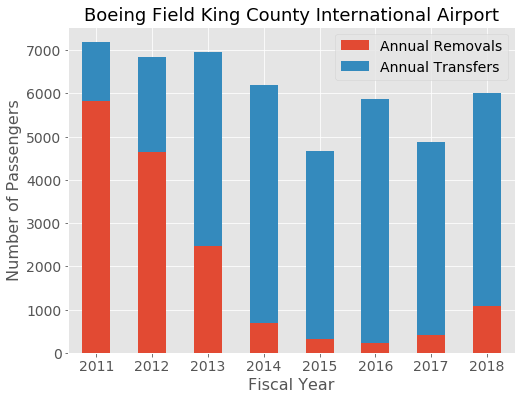

In [21]:
data = annual_summary[['Annual Removals', 'Annual Transfers']]
r_t_bar(data, airport, airport_name)
plt.show()

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [22]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [23]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

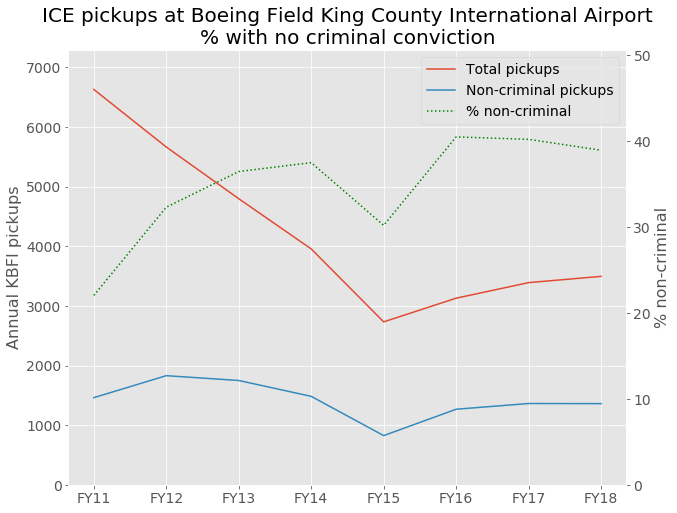

In [29]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by calendar year)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

Is this correct though? What we do below is calculate the mean of the monthly means for each year, which may not be right. We can just divide the yearly total by number of months to get monthly average.

Mean of means appears to be equivalent to total/number of months; at least it deals effectively with partial years.

In [30]:
pickup_df.groupby(pd.Grouper(freq='AS-OCT'))['AlienMasterID'].nunique()['2010':'2017']/12

MissionDate
2010-10-01    552.416667
2011-10-01    472.000000
2012-10-01    399.750000
2013-10-01    329.583333
2014-10-01    227.666667
2015-10-01    260.750000
2016-10-01    282.500000
2017-10-01    291.250000
Freq: AS-OCT, Name: AlienMasterID, dtype: float64

In [31]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [32]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2010,4.00,39.33,7.67,512.67
2011,4.42,59.00,8.33,544.17
2012,3.92,115.42,4.83,450.17
2013,3.17,165.25,4.08,383.58
2014,3.83,161.92,3.92,300.00
2015,3.17,209.00,2.83,237.67
2016,4.17,231.50,4.50,264.83
2017,3.50,120.92,4.25,288.50
2018,3.75,193.08,4.17,273.17


In [33]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [34]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                25133
GUATEMALA              3366
EL SALVADOR            2660
HONDURAS               2023
HAITI                   459
ECUADOR                 171
NICARAGUA               116
CAMBODIA                109
COLOMBIA                 51
DOMINICAN REPUBLIC       35
Name: CountryOfCitizenship, dtype: int64

In [35]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    3430
GUATEMALA      2554
MEXICO         2278
HONDURAS       1786
INDIA          1513
Name: CountryOfCitizenship, dtype: int64

In [36]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         27411
EL SALVADOR     6090
GUATEMALA       5920
HONDURAS        3809
INDIA           1543
Name: CountryOfCitizenship, dtype: int64

In [37]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [38]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [39]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [40]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [41]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = all_df.copy()
df_to_analyze.name = all_df.name

In [42]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [43]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [44]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [45]:
all_passenger_nationality_by_year

AlienMasterID                                          \
CountryOfCitizenship     ARGENTINA ARMENIA BOSNIA BRAZIL BULGARIA CAMBODIA   
FY                                                                           
2010-10-01                     1.0     1.0    1.0    1.0      2.0     11.0   
2011-10-01                     NaN     NaN    NaN    2.0      NaN      NaN   
2012-10-01                     1.0     NaN    NaN    3.0      NaN      2.0   
2013-10-01                     1.0     5.0    NaN    7.0      1.0     46.0   
2014-10-01                     2.0     4.0    1.0   17.0      NaN     10.0   
2015-10-01                     2.0    13.0    NaN   32.0      NaN    111.0   
2016-10-01                     NaN     2.0    NaN    NaN      1.0     10.0   
2017-10-01                     NaN     8.0    NaN   21.0      NaN     29.0   

                                                           ...               \
CountryOfCitizenship CAMEROON CANADA  CHINA COLOMBIA       ...        SAMOA   
FY                                                         ...                
2010-10-01                1.0    5.0   30.0      6.0       ...          NaN   
2011-10-01                2.0    NaN   11.0      9.0       ...          NaN   
2012-10-01                9.0    3.0    9.0     13.0       ...          NaN   
2013-10-01               20.0    3.0   16.0     12.0       ...          NaN   
2014-10-01                2.0    NaN   49.0      7.0       ...          NaN   
2015-10-01               27.0    2.0  152.0      8.0       ...          3.0   
2016-10-01               24.0    2.0   47.0     21.0       ...          NaN   
2017-10-01               45.0    3.0  100.0     13.0       ...          2.0   

                                                                              \
CountryOfCitizenship SPAIN MAURITANIA KYRGYSTAN DEMOCRATIC REPUBLIC OF CONGO   
FY                                                                             
2010-10-01             NaN        NaN       NaN                          NaN   
2011-10-01             NaN        NaN       NaN                          NaN   
2012-10-01             NaN        NaN       NaN                          NaN   
2013-10-01             NaN        NaN       NaN                          NaN   
2014-10-01             NaN        NaN       NaN                          NaN   
2015-10-01             NaN        NaN       NaN                          NaN   
2016-10-01             1.0        1.0       1.0                          1.0   
2017-10-01             1.0        1.0      10.0                          1.0   

                                                                             
CountryOfCitizenship ST. LUCIA SAUDI ARABIA JAPAN ZIMBABWE PAPUA NEW GUINEA  
FY                                                                           
2010-10-01                 NaN          NaN   NaN      NaN              NaN  
2011-10-01                 NaN          NaN   NaN      NaN              NaN  
2012-10-01                 NaN          NaN   NaN      NaN              NaN  
2013-10-01                 NaN          NaN   NaN      NaN              NaN  
2014-10-01                 NaN          NaN   NaN      NaN              NaN  
2015-10-01                 NaN          NaN   NaN      NaN              NaN  
2016-10-01                 1.0          NaN   NaN      NaN              NaN  
2017-10-01                 NaN          1.0   1.0      1.0              1.0  

[8 rows x 115 columns]

In [46]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [52]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

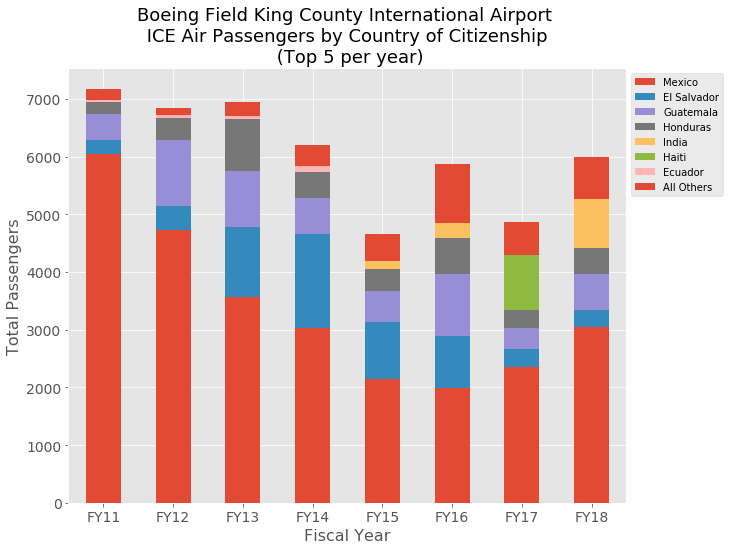

In [53]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [49]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary set of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [ ]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [ ]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)

In [ ]:
# Select arbitrary number of top values to display here
number_of_top_values = 6
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

In [ ]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air {df_to_analyze.name} at {airport} by Country of Citizenship',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [ ]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [ ]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [ ]:
juvenile_pickups

In [ ]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

In [ ]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [ ]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

# Detainee status

In [ ]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [ ]:
status = pd.read_csv('../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

problematic = ['2A', '2B', '5C', '5D', '5E', '5F', '8A', '8B', '8D', '8G', '8H', '11']

In [ ]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

In [ ]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [ ]:
total

# Airport report

For a each airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [27]:
def airport_report(airport_icao, print_report=False, figure=False):
    airport = airport_icao
    if airport.upper() in airport_dict.keys():
        pass
    else:
        print(f'{airport} not represented in dataset')
    airport_name = airport_dict[airport]
    pickup = df['PULOC'] == airport
    dropoff = df['DropLoc'] == airport

    pickup_df = df[pickup]
    dropoff_df = df[dropoff]

    first_pickup = pickup_df.MissionDate.min()
    last_pickup = pickup_df.MissionDate.max()
    first_dropoff = dropoff_df.MissionDate.min()
    last_dropoff = dropoff_df.MissionDate.max()

    pickup_df.set_index('MissionDate', inplace=True)
    dropoff_df.set_index('MissionDate', inplace=True)

    all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

    removal = all_df['R-T'] == 'R'
    transfer = all_df['R-T'] == 'T'
    removal_df = all_df[removal]
    transfer_df = all_df[transfer]

    all_df.name = 'Passengers'
    removal_df.name = 'Removals'
    transfer_df.name = 'Transfers'
    pickup_df.name = 'Pickups'
    dropoff_df.name = 'Dropoffs'

    # This grouped table would work for mapping flights from specific airports.
    all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID']].nunique()
    
    monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
    monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
    monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
    monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
    annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
    annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
    
    unique_pickups = len(set(pickup_df['AlienMasterID']))
    unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
    unique_removals = len(set(removal_df['AlienMasterID']))
    unique_transfers = len(set(transfer_df['AlienMasterID']))
    total_unique = len(set(all_df['AlienMasterID']))
    removal_percent = round(unique_removals / total_unique * 100, 2)
    transfer_percent = round(unique_transfers / total_unique * 100, 2)
    monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
    monthly_pickup_avg = round(monthly_pickups.mean(), 2)
    monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
    monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
    unique_pickup_missions = len(set(pickup_df['MissionID']))
    unique_dropoff_missions = len(set(dropoff_df['MissionID']))
    
    airport_vars = {airport:
                {'airport_name': airport_name,
                'unique_pickups': unique_pickups,
                'unique_dropoffs': unique_dropoffs,
                'unique_removals': unique_removals,
                'unique_transfers': unique_transfers,
                'total_unique': total_unique,
                'removal_percent': removal_percent,
                'transfer_percent': transfer_percent,
                'monthly_dropoff_avg': monthly_dropoff_avg,
                'monthly_pickup_avg': monthly_pickup_avg,
                'monthly_dropoff_mission_avg': monthly_dropoff_mission_avg,
                'monthly_pickup_mission_avg': monthly_pickup_mission_avg,
                'unique_pickup_missions': unique_pickup_missions,
                'unique_dropoff_missions': unique_dropoff_missions}}
    
    row = pd.DataFrame(airport_vars).T
    
    if print_report == True:
        print(f'{airport} ({airport_name})')
        print(f'---------------------------------------------------------')
        print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
        print(f'{unique_removals} removals, {unique_transfers} transfers.')
        print(f"{total_unique} total unique passengers.")
        print(f"{removal_percent}% removals, {transfer_percent}% transfers")
        print(f'{monthly_dropoff_avg} average dropoffs per month.')
        print(f'{monthly_pickup_avg} average pickups per month.')
        print()
        print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
        print(f"{all_df['MissionID'].nunique()} total missions.")
        print(f'{monthly_dropoff_mission_avg} average dropoff missions per month.')
        print(f'{monthly_pickup_mission_avg} average pickup missions per month.')
        print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
        print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')

    if figure == True:
        fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
        annual_removals.rename('Total removals', inplace=True)
        annual_transfers.rename('Total transfers', inplace=True)
        annual_summary = pd.DataFrame({
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers}, index=fy_index)
        annual_summary.index = annual_summary.index.year+1 
        annual_summary.index.name = 'Fiscal Year'
        data = annual_summary[['Annual Removals', 'Annual Transfers']]
        r_t_bar(data, airport, airport_name)

    return(row)

In [16]:
airport_df = pd.DataFrame()
for key in airport_dict.keys():
    try:
        row = airport_report(key)
    except AttributeError:
        pass
    airport_df = airport_df.append(row)
airport_df.to_csv('../output/all_airport_vars.csv')

In [18]:
airport_df.head()

,airport_name,monthly_dropoff_avg,monthly_dropoff_mission_avg,monthly_pickup_avg,monthly_pickup_mission_avg,removal_percent,total_unique,transfer_percent,unique_dropoff_missions,unique_dropoffs,unique_pickup_missions,unique_pickups,unique_removals,unique_transfers
BKPR,Pristina International Airport,0.06,0.05,NaN,NaN,100,4,0,3,4,0,0,4,0
DAAG,Houari Boumediene Airport,3,1,NaN,NaN,100,3,0,1,3,0,0,3,0
DFFD,Ouagadougou Airport,5,1,NaN,NaN,100,5,0,1,5,0,0,5,0
DGAA,Kotoka International Airport,3.76,0.09,NaN,NaN,100,350,0,8,350,0,0,350,0
DIAP,Port Bouet Airport,0.32,0.06,NaN,NaN,100,31,0,6,31,0,0,31,0


In [28]:
for key in airport_dict.keys():
    try:
        airport_report(airport_icao=key, figure=True)
    except AttributeError:
        pass

BKPR
DAAG
DFFD
DGAA
DIAP
DNMM
DRRN
DXXX
EDDF
EGGW
EGSS
EPWA
EYVI
FALA
FCBB
FGSL
FKKD
FKYS
FLKK
FOOL
FTTJ
FVHA
FWKI
FYWH
FZAA
GABS
GBYD
GFLL
GLRB
GMMN
GOOY
GQNO
GUCY
GVAC
GVNP
HAAB
HBBA
HCMM
HECA
HKJK
HRYR
HSSJ
HSSS
HTDA
HUEN
KABI
KABQ
KAEX
KALB
KATL
KAUS
KBDL
KBED
KBFI
KBFL
KBLV
KBNA
KBOI
KBOS
KBRO
KBUF
KBWI
KCHS
KCLE
KCLT
KCMH
KCOS
KCRP
KCSG
KCVG
KDAL
KDEN
KDFW
KDTW
KELP
KEWR
KFTW
KGFK
KGRK
KGYY
KHRL
KHST
KIAD
KIAG
KIAH
KIWA
KJAX
KKBL
KLAS
KLAW
KLIT
KLRD
KMCI
KMDT
KMDW
KMEM
KMHR
KMIA
KMSP
KMWA
KNJK
KNTD
KNYL
KOAK
KOMA
KONT
KOPF
KORD
KPAE
KPDX
KPSM
KRFD
KRIC
KRNO
KROW
KSAN
KSAT
KSDM
KSKF
KSLC
KSMF
KSTL
KTEB
KTOL
KTUS
KTWF
KVCV
KYIP
KYKM
KYNG
LATI
LEMD
LFPB
LHBP
LIRA
LKPR
LLBG
LPPD
LQSA
LRBS
LROP
LTBA
LUKK
LWSK
LYBE
LYPG
LZIB
MDSD
MGGT
MHLM
MHSC
MHTG
MKJP
MMMD
MMMX
MNMG
MPTO
MSLP
MTPP
MUHA
MYNN
MZBZ
NFTF
NSFA
NZWN
OAKB
OJAI
OJAM
OLBA
OMDW
OPRN
ORBI
OYSN
PHNL
PKMJ
RCTP
RJBB
RPLL
SAEZ
SBBR
SBCF
SBGR
SEGU
SKBO
SLLP
SLVR
SMJP
SPIM
SPJC
SUMU
SYCJ
TAPA
TBPB
TDPD
TGPY
TIST
TJBQ
TJSJ
TKPK
TLPL


In [ ]:
# SPIM == SPJC